Predicting Hypoxic Regions Using ConvLSTM with Oversampling and Stratified K-Fold Cross-Validation


This pipeline uses a ConvLSTM-based deep learning model for predicting hypoxic regions (low oxygen levels) in marine waters. The model leverages temporal-spatial patterns in oceanographic data.

1. Dataset Preparation

    The dataset is preprocessed by normalizing features using StandardScaler to ensure uniformity and scale independence.
    The data is split into an 80% training set and a 20% holdout set for evaluation.
    SMOTE (Synthetic Minority Oversampling Technique) is applied to address the class imbalance between hypoxic and non-hypoxic regions, ensuring fair training.

Dataset Summary:
            Latitude      Longitude         Depth   Oxygen_Value  \
count  133549.000000  133549.000000  133549.00000  133549.000000   
mean       -6.227246     -10.923800    1218.44821     199.062570   
std        44.017819     110.337699    1317.86417      78.527776   
min       -77.500000    -177.500000       5.00000       0.000000   
25%       -42.500000    -112.500000     100.00000     154.227000   
50%       -12.500000     -17.500000     700.00000     203.070000   
75%        22.500000      87.500000    1900.00000     247.129000   
max        87.500000     177.500000    5500.00000     457.073000   

       Salinity_Value  Temperature_Value  
count   133549.000000      133549.000000  
mean        34.648312           6.429536  
std          1.125943           7.671785  
min          4.795000          -2.042000  
25%         34.490000           1.477000  
50%         34.683000           3.024000  
75%         34.897000           9.386000  
max         40.573000     

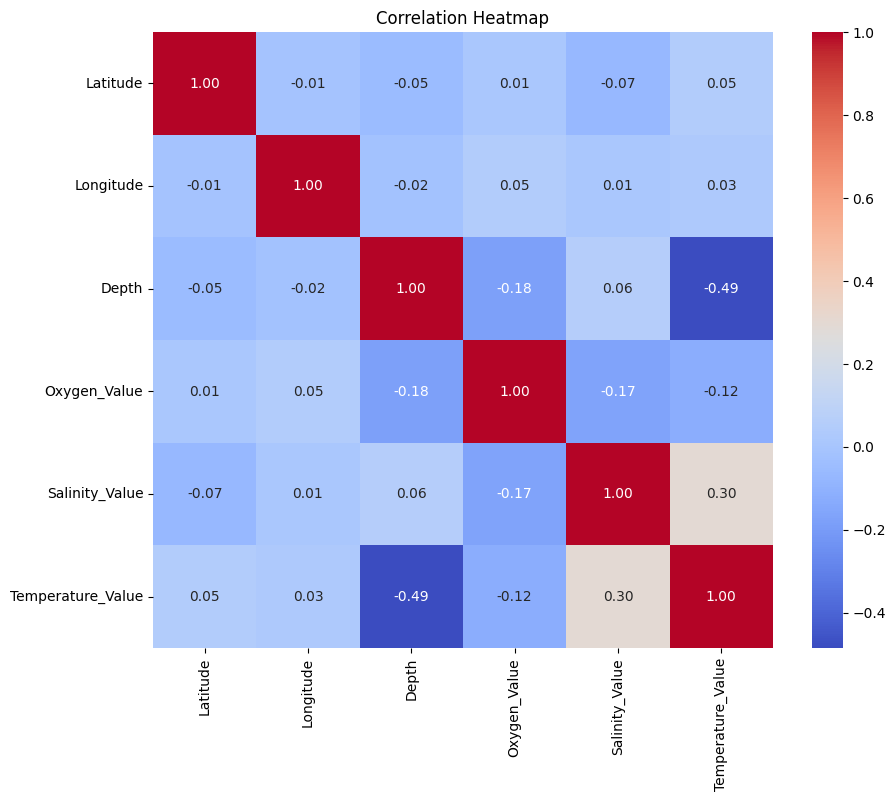

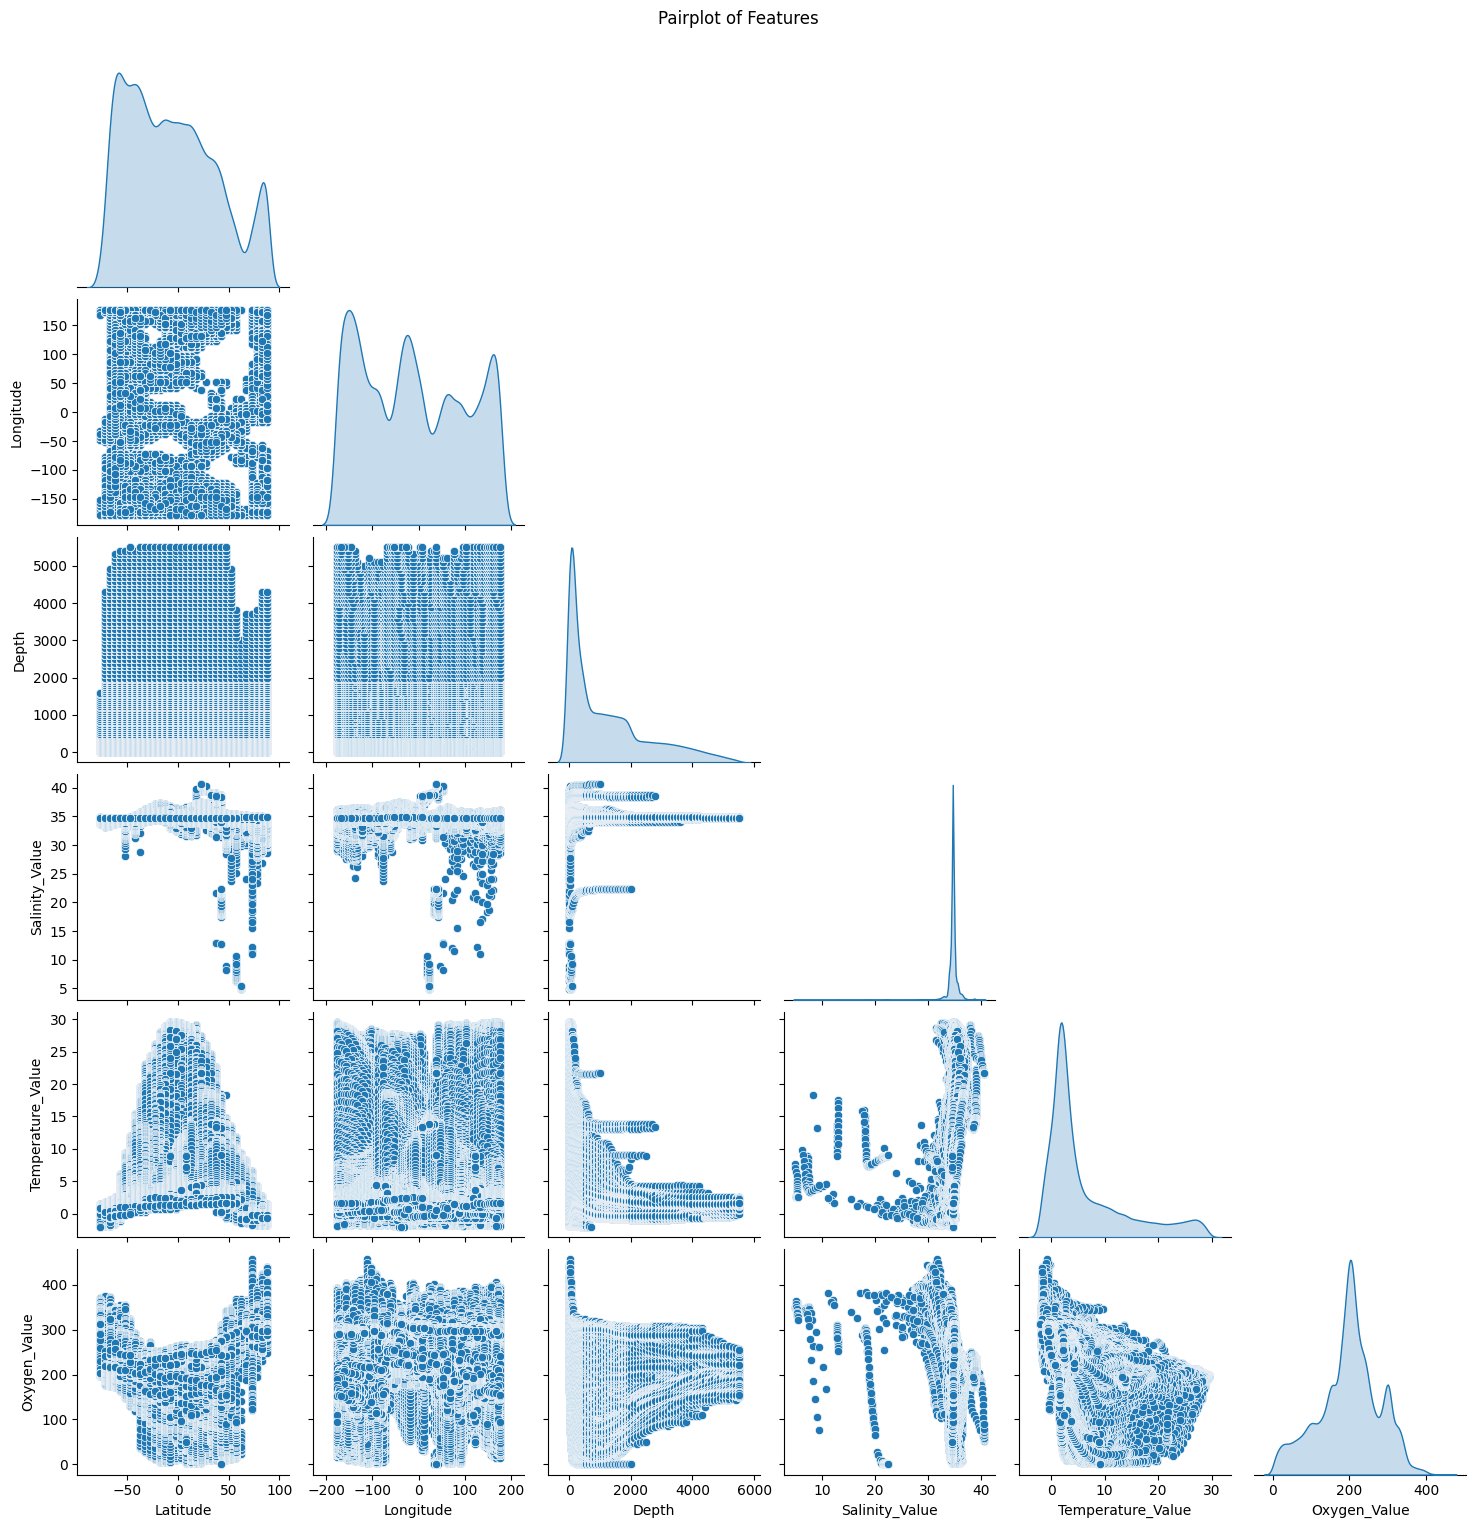

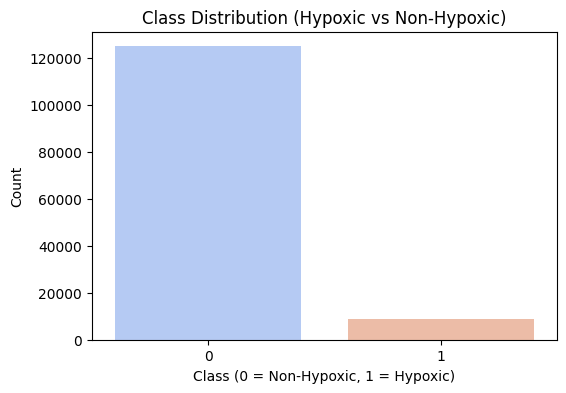

Class distribution in Train: Counter({0: 99833, 1: 7006})
Class distribution in Holdout: Counter({0: 24959, 1: 1751})


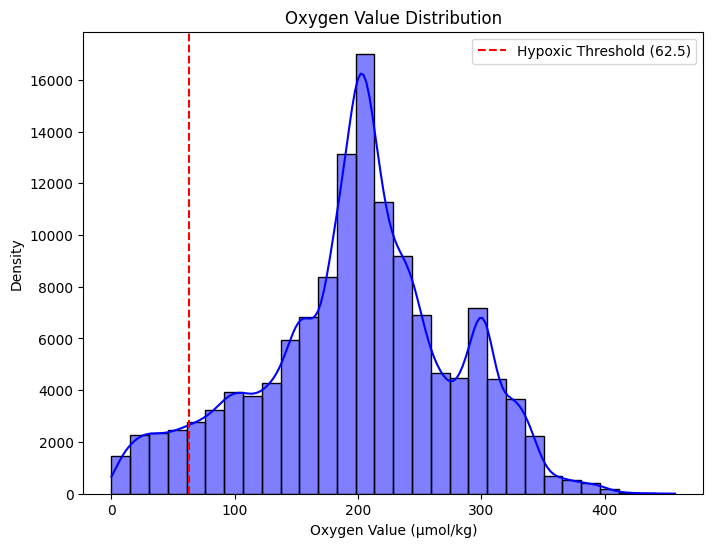

Class distribution in Train: Counter({0: 99833, 1: 7006})
Class distribution in Holdout: Counter({0: 24959, 1: 1751})


In [12]:
# Import Libraries
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, BatchNormalization, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('combined_oceanographic_data.csv')

# EDA: Basic Statistics
print("Dataset Summary:")
print(data.describe())

# EDA: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# EDA: Pairplot of features
sns.pairplot(
    data[['Latitude', 'Longitude', 'Depth', 'Salinity_Value', 'Temperature_Value', 'Oxygen_Value']],
    diag_kind='kde',
    palette='coolwarm',
    corner=True
)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

# Define the hypoxic threshold (62.5 µmol/kg)
hypoxic_threshold = 62.5
data['Hypoxic'] = (data['Oxygen_Value'] <= hypoxic_threshold).astype(int)  # 1 = Hypoxic, 0 = Non-Hypoxic

# EDA: Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data['Hypoxic'], palette='coolwarm')
plt.title("Class Distribution (Hypoxic vs Non-Hypoxic)")
plt.xlabel("Class (0 = Non-Hypoxic, 1 = Hypoxic)")
plt.ylabel("Count")
plt.show()

# Extract features and target
features = data[['Latitude', 'Longitude', 'Depth', 'Salinity_Value', 'Temperature_Value']].values
oxygen_values = data['Oxygen_Value'].values
labels = data['Hypoxic'].values

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into a train/holdout split
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print class distributions
print("Class distribution in Train:", Counter(y_train_full))
print("Class distribution in Holdout:", Counter(y_holdout))

# EDA: Distribution of Oxygen Values
plt.figure(figsize=(8, 6))
sns.histplot(data['Oxygen_Value'], kde=True, bins=30, color='blue')
plt.axvline(x=hypoxic_threshold, color='red', linestyle='--', label=f'Hypoxic Threshold ({hypoxic_threshold})')
plt.title("Oxygen Value Distribution")
plt.xlabel("Oxygen Value (µmol/kg)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Load Dataset
data = pd.read_csv("combined_oceanographic_data.csv")

# Feature and Target Extraction
features = data[['Latitude', 'Longitude', 'Depth', 'Salinity_Value', 'Temperature_Value']].values
oxygen_values = data['Oxygen_Value'].values
hypoxic_threshold = 62.5
labels = (oxygen_values <= hypoxic_threshold).astype(int)  # Binary target

# Normalize Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Stratified Train-Test Split (Holdout Set)
X_train, X_holdout, y_train, y_holdout = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"Class distribution in Train: {Counter(y_train)}")
print(f"Class distribution in Holdout: {Counter(y_holdout)}")


2. Sequence Creation for ConvLSTM

In [4]:
# Create Sequential Data for ConvLSTM
def create_sequences(data, labels, sequence_length=5):
    sequences, seq_labels = [], []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        label = labels[i + sequence_length - 1]
        sequences.append(seq)
        seq_labels.append(label)
    return np.array(sequences), np.array(seq_labels)

sequence_length = 3
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_holdout_seq, y_holdout_seq = create_sequences(X_holdout, y_holdout, sequence_length)


3. Stratified K-Fold Cross-Validation with SMOTE

Explanation:

    SMOTE balances classes in each fold.
    ConvLSTM processes the temporal-spatial data.
    Metrics (accuracy, ROC-AUC, classification report) are calculated and visualized for each fold.

=== Fold 1/5 ===
Class distribution after SMOTE (Fold 1): Counter({1: 79865, 0: 79865})
Epoch 1/5


2024-12-14 10:10:56.505520: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-14 10:10:56.505569: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: zmey1-HP-Pavilion-Gaming-Laptop-15-ec0xxx
2024-12-14 10:10:56.505579: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: zmey1-HP-Pavilion-Gaming-Laptop-15-ec0xxx
2024-12-14 10:10:56.505891: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-14 10:10:56.505974: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-14 10:10:56.505990: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0
/home/zmey1/anaconda3/envs/LLM/lib/python3.1

4992/4992 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8883 - loss: 0.2619 - val_accuracy: 0.9503 - val_loss: 0.1132
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9613 - loss: 0.1041 - val_accuracy: 0.9620 - val_loss: 0.0915
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9690 - loss: 0.0832 - val_accuracy: 0.9663 - val_loss: 0.0852
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9714 - loss: 0.0780 - val_accuracy: 0.9658 - val_loss: 0.0906
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9739 - loss: 0.0716 - val_accuracy: 0.9688 - val_loss: 0.0766
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19967
           1       0.68      0.97      0.80      1401

    accuracy                           0.97     21368
   macro avg       0.84      0.97      0.89     21368
weighted avg       0.98

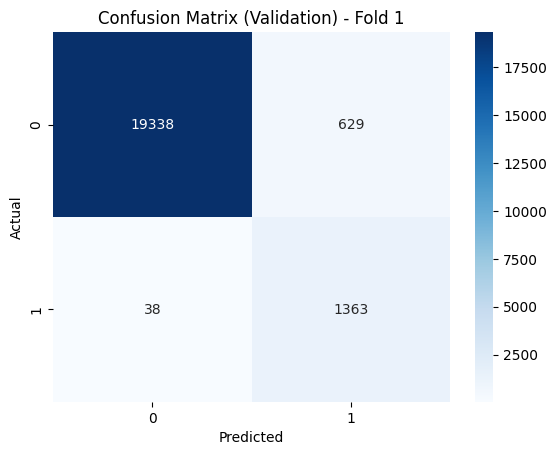

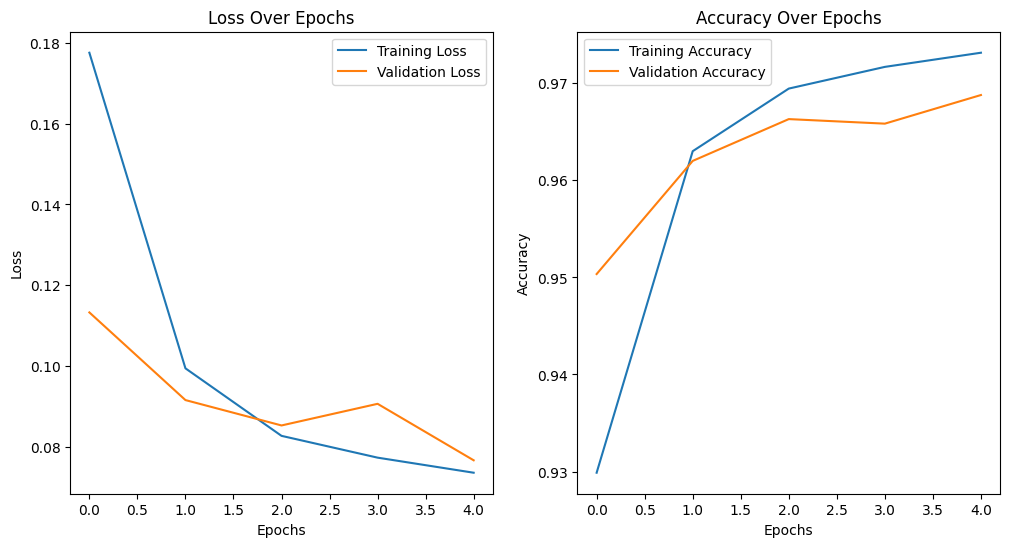

=== Fold 2/5 ===
Class distribution after SMOTE (Fold 2): Counter({1: 79865, 0: 79865})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.8884 - loss: 0.2584 - val_accuracy: 0.9566 - val_loss: 0.0948
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9610 - loss: 0.1046 - val_accuracy: 0.9626 - val_loss: 0.0937
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9674 - loss: 0.0877 - val_accuracy: 0.9648 - val_loss: 0.0898
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9702 - loss: 0.0823 - val_accuracy: 0.9669 - val_loss: 0.0904
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9726 - loss: 0.0747 - val_accuracy: 0.9667 - val_loss: 0.0879
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19967
           1       0.67      0.97      0.79      1401

    accuracy                           0.97     21368
   macro avg       0.83      0.97      0.89     21368
weighted avg       0.98

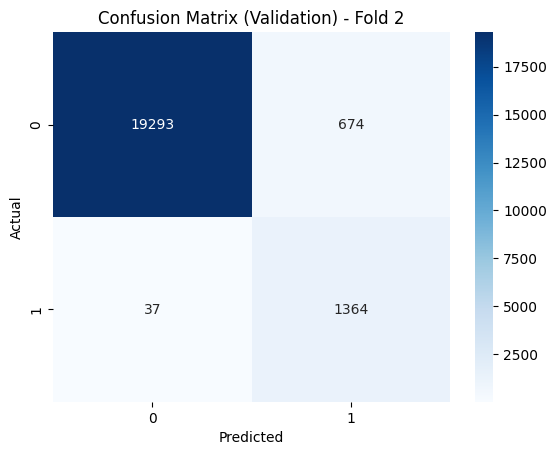

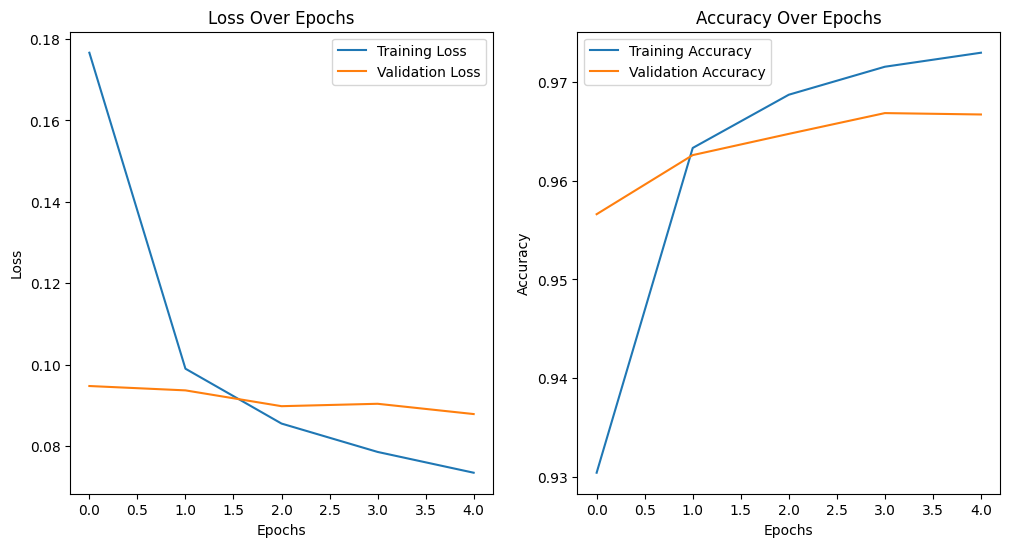

=== Fold 3/5 ===
Class distribution after SMOTE (Fold 3): Counter({0: 79866, 1: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8916 - loss: 0.2547 - val_accuracy: 0.9526 - val_loss: 0.1106
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9606 - loss: 0.1046 - val_accuracy: 0.9612 - val_loss: 0.0979
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9679 - loss: 0.0867 - val_accuracy: 0.9583 - val_loss: 0.1081
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9716 - loss: 0.0772 - val_accuracy: 0.9695 - val_loss: 0.0776
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9733 - loss: 0.0741 - val_accuracy: 0.9692 - val_loss: 0.0817
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19966
           1       0.69      0.97      0.81      1401

    accuracy                           0.97     21367
   macro avg       0.84      0.97      0.89     21367
weighted avg       0.98

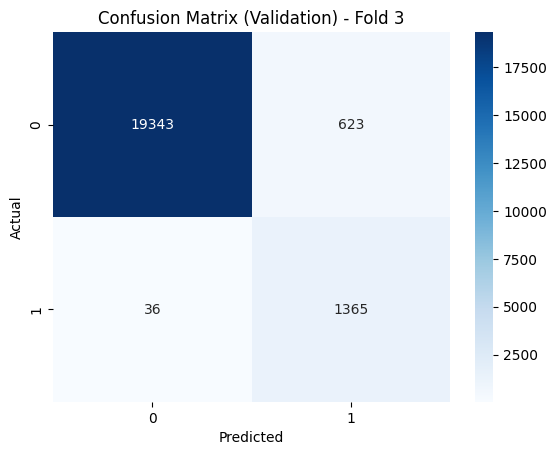

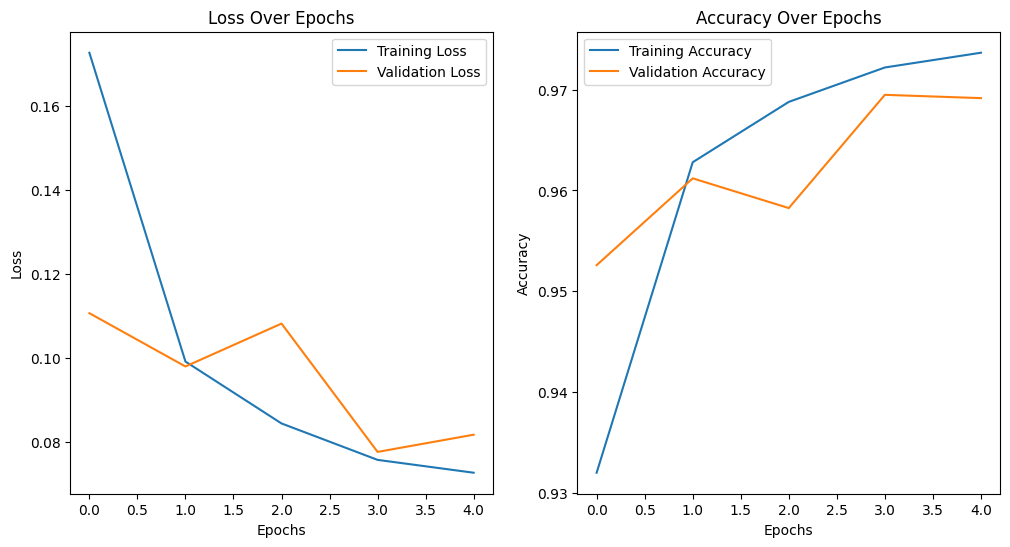

=== Fold 4/5 ===
Class distribution after SMOTE (Fold 4): Counter({1: 79866, 0: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.8913 - loss: 0.2596 - val_accuracy: 0.9503 - val_loss: 0.1127
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9592 - loss: 0.1089 - val_accuracy: 0.9632 - val_loss: 0.0865
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9661 - loss: 0.0897 - val_accuracy: 0.9593 - val_loss: 0.1019
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9693 - loss: 0.0826 - val_accuracy: 0.9624 - val_loss: 0.1033
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9724 - loss: 0.0740 - val_accuracy: 0.9744 - val_loss: 0.0615
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19966
           1       0.73      0.97      0.83      1401

    accuracy                           0.97     21367
   macro avg       0.86      0.97      0.91     21367
weighted avg       0.98

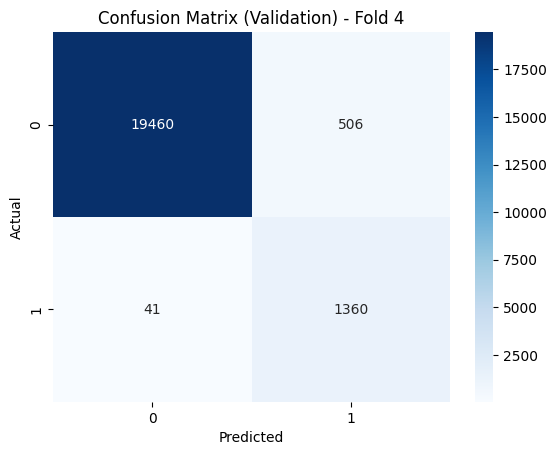

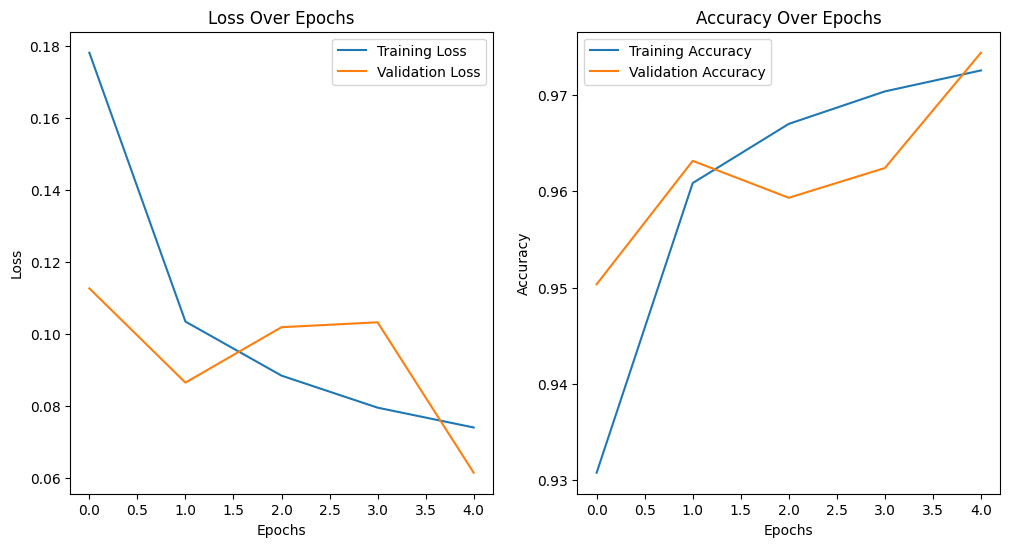

=== Fold 5/5 ===
Class distribution after SMOTE (Fold 5): Counter({1: 79866, 0: 79866})
Epoch 1/5


/home/zmey1/anaconda3/envs/LLM/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.8933 - loss: 0.2524 - val_accuracy: 0.9437 - val_loss: 0.1353
Epoch 2/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9604 - loss: 0.1075 - val_accuracy: 0.9603 - val_loss: 0.0996
Epoch 3/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9670 - loss: 0.0886 - val_accuracy: 0.9662 - val_loss: 0.0830
Epoch 4/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9703 - loss: 0.0825 - val_accuracy: 0.9646 - val_loss: 0.0900
Epoch 5/5
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9722 - loss: 0.0754 - val_accuracy: 0.9694 - val_loss: 0.0771
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19966
           1       0.69      0.96      0.80      1401

    accuracy                           0.97     21367
   macro avg       0.84      0.97      0.89     21367
weighted avg       0.98

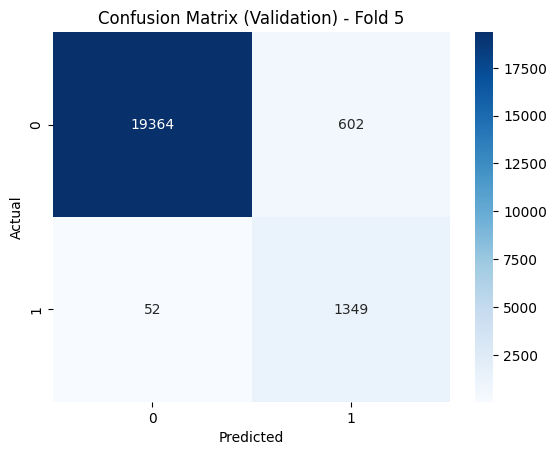

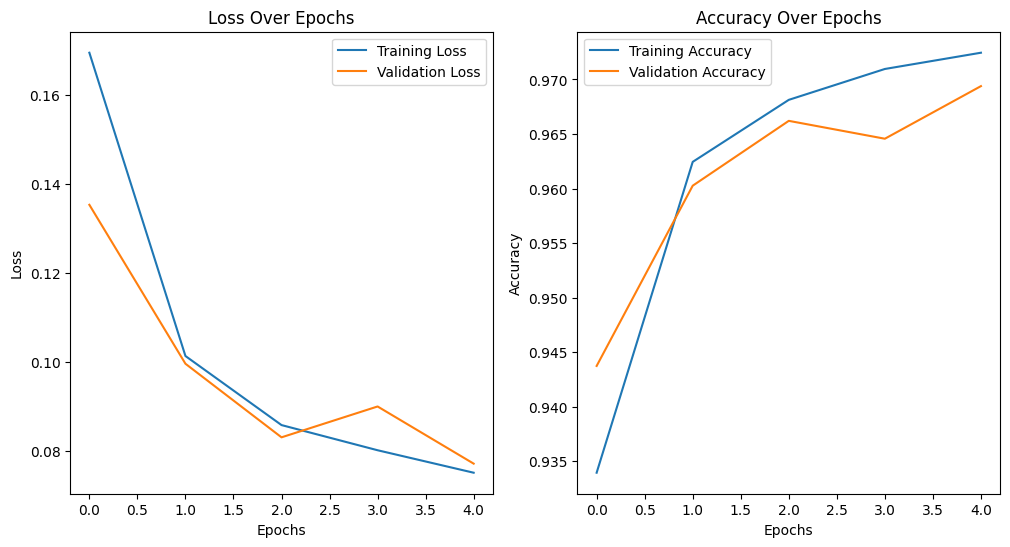

In [5]:
# Stratified K-Fold Cross-Validation with SMOTE
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores, roc_auc_scores, precision_scores, recall_scores = [], [], [], []
fold = 1

for train_index, val_index in skf.split(X_train_seq, y_train_seq):
    print(f"=== Fold {fold}/{n_splits} ===")
    
    # Split into train and validation sets
    X_train_fold, X_val_fold = X_train_seq[train_index], X_train_seq[val_index]
    y_train_fold, y_val_fold = y_train_seq[train_index], y_train_seq[val_index]
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(
        X_train_fold.reshape(-1, sequence_length * X_train_fold.shape[2]),
        y_train_fold
    )
    X_train_res = X_train_res.reshape(-1, sequence_length, 1, 1, X_train_fold.shape[2])
    
    print(f"Class distribution after SMOTE (Fold {fold}): {Counter(y_train_res)}")
    
    # Reshape Validation Data
    X_val_fold = X_val_fold.reshape(-1, sequence_length, 1, 1, X_val_fold.shape[2])
    
    # ConvLSTM Model
    model = Sequential([
        ConvLSTM2D(32, (1, 1), activation='relu', input_shape=(sequence_length, 1, 1, X_train_fold.shape[2])),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train Model
    history = model.fit(
        X_train_res, y_train_res,
        validation_data=(X_val_fold, y_val_fold),
        epochs=5,
        batch_size=32,
        verbose=1
    )
    
    # Evaluate Validation Performance
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy_scores.append(val_accuracy)
    
    # Predict and Calculate Metrics
    y_val_pred = model.predict(X_val_fold).flatten()
    y_val_pred_classes = (y_val_pred >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_val_fold, y_val_pred)
    roc_auc_scores.append(roc_auc)
    
    # Precision-Recall Calculation
    precision, recall, _ = precision_recall_curve(y_val_fold, y_val_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    print("\nClassification Report:")
    print(classification_report(y_val_fold, y_val_pred_classes))
    
    print("\nConfusion Matrix:")
    sns.heatmap(confusion_matrix(y_val_fold, y_val_pred_classes), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Validation) - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Accuracy and Loss Curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
    fold += 1


### 5. Final Metrics and Holdout Set Evaluation

    Confusion Matrix (Holdout Test Set):
        True Negatives (0, 0): 24,231 non-hypoxic regions correctly classified.
        False Positives (0, 1): 726 non-hypoxic regions misclassified as hypoxic.
        False Negatives (1, 0): 52 hypoxic regions missed.
        True Positives (1, 1): 1,699 hypoxic regions correctly classified.

    Classification Report:
        Precision (Hypoxic): 70%, indicating the proportion of predicted hypoxic regions that are correct.
        Recall (Hypoxic): 97%, showing the model's ability to detect nearly all hypoxic regions.
        F1-Score (Hypoxic): 81%, balancing precision and recall.
        Accuracy: 97%, indicating strong overall performance.
        Macro Average: Highlights balanced performance across classes (0.85–0.97 range).
        Weighted Average: Reflects high model reliability due to class distribution dominance.

This demonstrates the model's strong ability to detect hypoxic regions with minimal false negatives while maintaining high overall accuracy.


=== Final Metrics Across Folds ===
Mean Accuracy: 0.9697 ± 0.0025
Mean ROC-AUC: 0.9962 ± 0.0003
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Final Holdout Test Set Results ===
Holdout Test Loss: 0.0727, Holdout Test Accuracy: 0.9709
Holdout ROC-AUC: 0.9961

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     24957
           1       0.70      0.97      0.81      1751

    accuracy                           0.97     26708
   macro avg       0.85      0.97      0.90     26708
weighted avg       0.98      0.97      0.97     26708



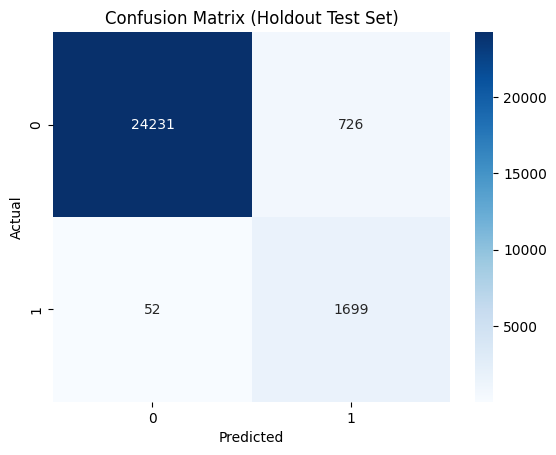

In [6]:
# Final Metrics Summary
print("\n=== Final Metrics Across Folds ===")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

# Evaluate Holdout Set
X_holdout_seq = X_holdout_seq.reshape(-1, sequence_length, 1, 1, X_holdout_seq.shape[2])
holdout_loss, holdout_accuracy = model.evaluate(X_holdout_seq, y_holdout_seq, verbose=0)
y_holdout_pred = model.predict(X_holdout_seq).flatten()
y_holdout_pred_classes = (y_holdout_pred >= 0.5).astype(int)

holdout_roc_auc = roc_auc_score(y_holdout_seq, y_holdout_pred)

print("\n=== Final Holdout Test Set Results ===")
print(f"Holdout Test Loss: {holdout_loss:.4f}, Holdout Test Accuracy: {holdout_accuracy:.4f}")
print(f"Holdout ROC-AUC: {holdout_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_holdout_seq, y_holdout_pred_classes))

sns.heatmap(confusion_matrix(y_holdout_seq, y_holdout_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Holdout Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Visualizations

1. Class Balance Before and After SMOTE:

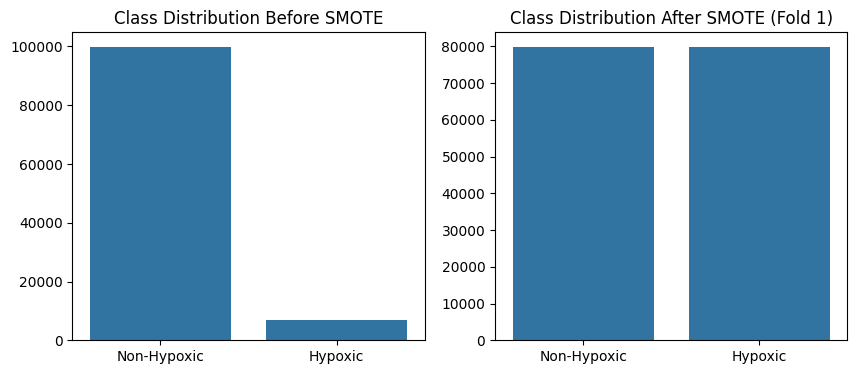

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=['Non-Hypoxic', 'Hypoxic'], y=pd.Series(y_train).value_counts().values)
plt.title("Class Distribution Before SMOTE")
plt.subplot(1, 2, 2)
sns.barplot(x=['Non-Hypoxic', 'Hypoxic'], y=[79867, 79867])
plt.title("Class Distribution After SMOTE (Fold 1)")
plt.show()


2. Precision-Recall Curve:

The Area Under the Curve (AUC = 0.9488) indicates a high balance between precision and recall. The curve's consistent shape across high recall values (close to 1) demonstrates the model's strong ability to capture most true hypoxic regions while maintaining good precision, minimizing false positives.

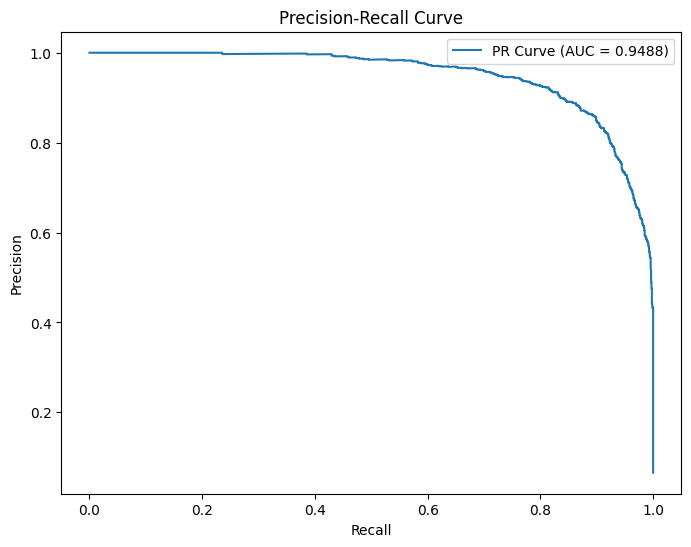

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {auc(recall, precision):.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


3. ROC Curve:

The Area Under the Curve (AUC = 0.9958) demonstrates excellent model performance, indicating high discriminatory power to distinguish between hypoxic and non-hypoxic regions across different classification thresholds.

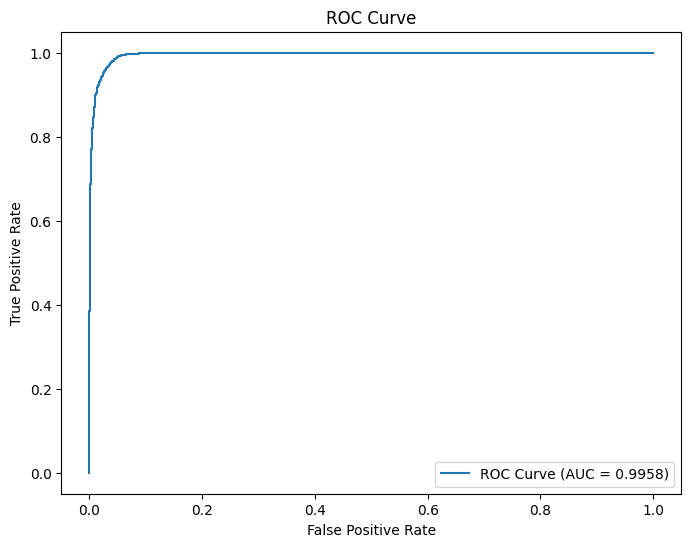

In [9]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val_fold, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
model.save('convlstm_model.h5')